In [95]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNetCV, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
file_path = "energydata_complete.csv"
df = pd.read_csv(file_path)

# Data preprocessing

In [72]:
# Convert date column to datetime format (instead of object)
df['date'] = pd.to_datetime(df['date'])

# set date as index because we have 10min intervals i.e uniqueness 
df.set_index('date', inplace=True) 

# To analyse temporal tendencies and have meaningful features, we create the hour, day of the week, month and year features from the date index
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

In [73]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,day_of_week,month
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,17,0,1
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,17,0,1
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,17,0,1
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,17,0,1
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,17,0,1


In [74]:
# Separate features and target variable
# Drop 'Appliances' and 'rv1', 'rv2' as they are not features but target variable and irrelevant variables respectively
X = df.drop(columns=['Appliances', 'rv1', 'rv2'])  
y = df['Appliances']

X.shape, y.shape

((19735, 28), (19735,))

In [75]:
# Let's encode categorical variables using one-hot encoding
X = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour'], drop_first=True)

In [76]:
X.shape # from 28 to 58 features 

(19735, 58)

In [77]:
# Let's normalize the data to avoid bias towards any feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

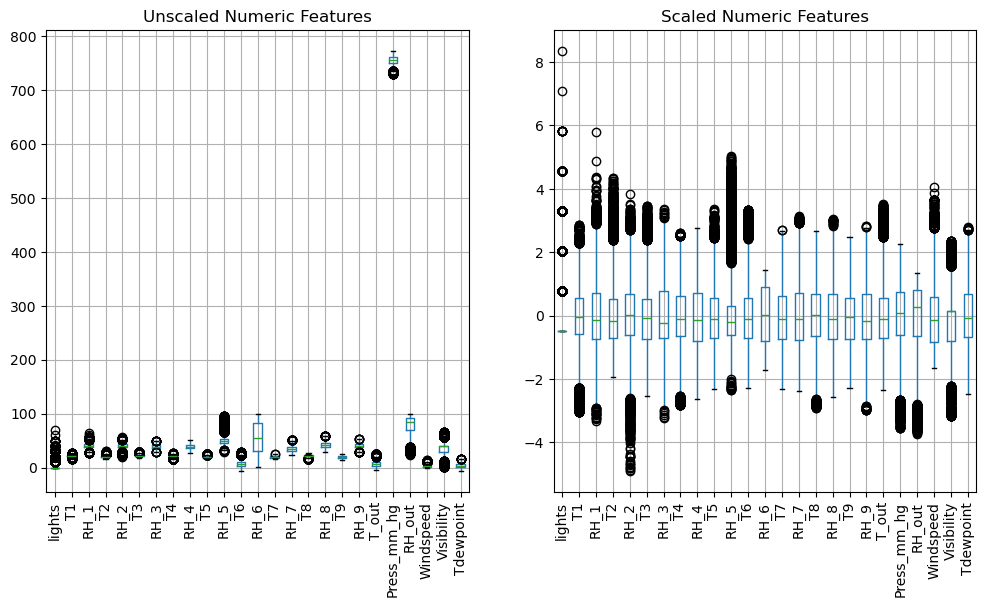

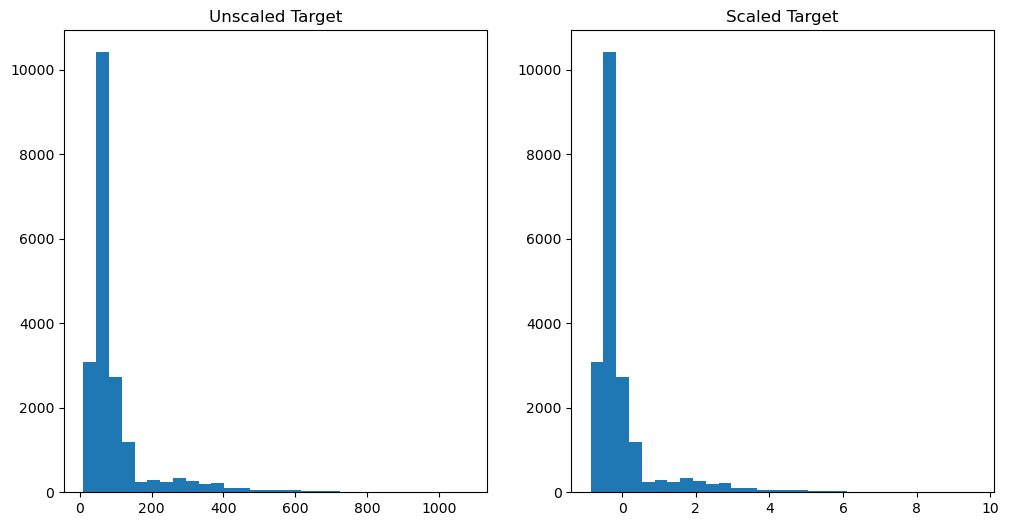

In [78]:
# Define prefixes for dummy categorical features
dummy_prefixes = ['hour_', 'day_of_week_', 'month_']

# Get numeric feature columns (exclude dummy categorical features)
numeric_cols = [col for col in X.columns if not any(col.startswith(prefix) for prefix in dummy_prefixes)]

# Create dataframes using only numeric features
X_df = pd.DataFrame(X, columns=X.columns)[numeric_cols]
X_df_scaled = pd.DataFrame(X_scaled, columns=X.columns)[numeric_cols]

# Plot boxplots for unscaled vs scaled numeric features
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Unscaled Numeric Features')
X_df.boxplot(figsize=(12, 6))
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.title('Scaled Numeric Features')
X_df_scaled.boxplot(figsize=(12, 6))
plt.xticks(rotation=90)
plt.show()

# Target distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Unscaled Target')
plt.hist(y, bins=30)
plt.subplot(1, 2, 2)
plt.title('Scaled Target')
plt.hist(y_scaled, bins=30)
plt.show()

# This illustrates that (numeric) features are now on the same scale.
# It was crucial to scale the data before splitting it into train and test sets.


In [79]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
# Check the shape of the train and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((15788, 58), (3947, 58), (15788, 1), (3947, 1))

# Linear Regression 

In [90]:
# first we create an evaluation function to evaluate the model performance
# so that we can reuse it for different models

def evaluate_linear_model(model, X_test, y_test, feature_names=None):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Print the evaluation metrics
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'R^2: {r2:.2f}')
    
    # Calculate residuals
    residuals = y_pred - y_test

    # Determine number of subplots (add one if feature importances are available)
    if hasattr(model, "coef_") and feature_names is not None:
        n_plots = 5
        # Create a grid of 2 rows x 3 columns and use the first 5 axes.
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        ax1, ax2, ax3, ax4, ax5 = axes.ravel()[:5]
    else:
        n_plots = 4
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        ax1, ax2, ax3, ax4 = axes.ravel()

    # Plot 1: Predicted vs Actual (Line Plot)
    ax1.plot(y_test, label='Actual', color='blue', alpha=0.5)
    ax1.plot(y_pred, label='Predicted', color='orange', alpha=0.5)
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('Target Value')
    ax1.set_title('Predicted vs Actual (Line Plot)')
    ax1.legend()

    # Plot 2: Predicted vs Actual (Scatter Plot)
    ax2.scatter(y_test, y_pred, alpha=0.5)
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    ax2.set_title('Predicted vs Actual (Scatter)')
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

    # Plot 3: Residuals vs Predicted Values
    ax3.scatter(y_pred, residuals, alpha=0.5)
    ax3.axhline(0, color='red', linestyle='--')
    ax3.set_xlabel('Predicted Values')
    ax3.set_ylabel('Residuals')
    ax3.set_title('Residuals vs Predicted')

    # Plot 4: Distribution of Residuals (Histogram)
    ax4.hist(residuals, bins=30, alpha=0.7, color='blue')
    ax4.axvline(0, color='red', linestyle='--')
    ax4.set_xlabel('Residuals')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Residuals Distribution')

    # Plot 5: Feature Importances (if available)
    if hasattr(model, "coef_") and feature_names is not None:
        importances = np.ravel(model.coef_)
        indices = np.argsort(np.abs(importances))[::-1]
        ax5.bar(range(len(importances)), importances[indices], align='center')
        ax5.set_xticks(range(len(importances)))
        ax5.set_xticklabels(np.array(feature_names)[indices], rotation=90)
        ax5.set_xlim([-1, len(importances)])
        ax5.set_title('Feature Importances')

    plt.tight_layout()
    plt.show()
    
    

In [81]:
# Basic linear regression model
lin_model = LinearRegression()

MAE: 0.51
MSE: 0.79
RMSE: 0.89
R^2: 0.17


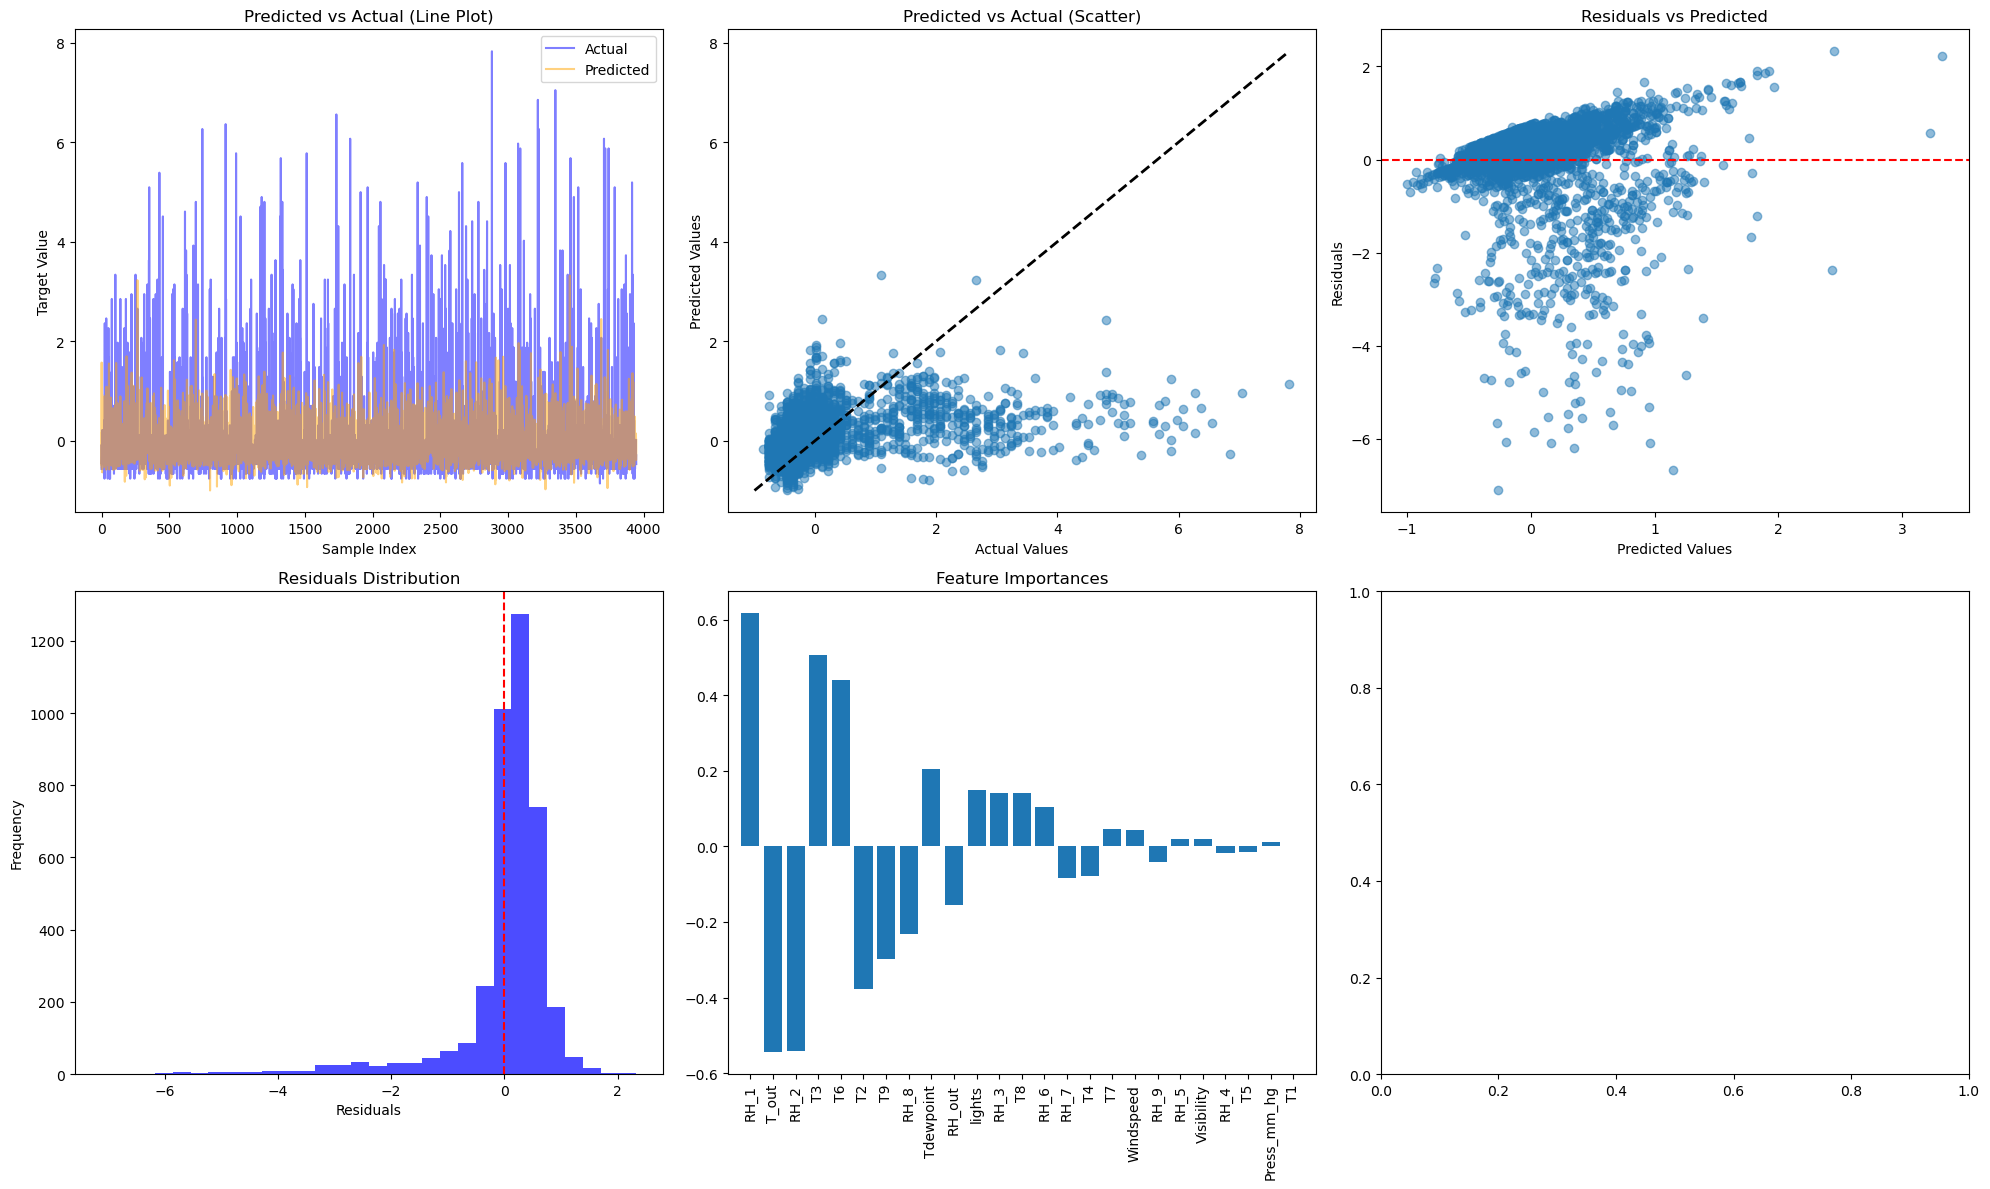

In [91]:
# Let's fit the model without the categorical features
X_train_num = X_train[:, :len(numeric_cols)]
X_test_num = X_test[:, :len(numeric_cols)]
# Fit the model
lin_model.fit(X_train_num, y_train)
# Evaluate the model
evaluate_linear_model(lin_model, X_test_num, y_test, feature_names=numeric_cols)
# It performs poorly 

MAE: 0.52
MSE: 0.81
RMSE: 0.90
R^2: 0.15


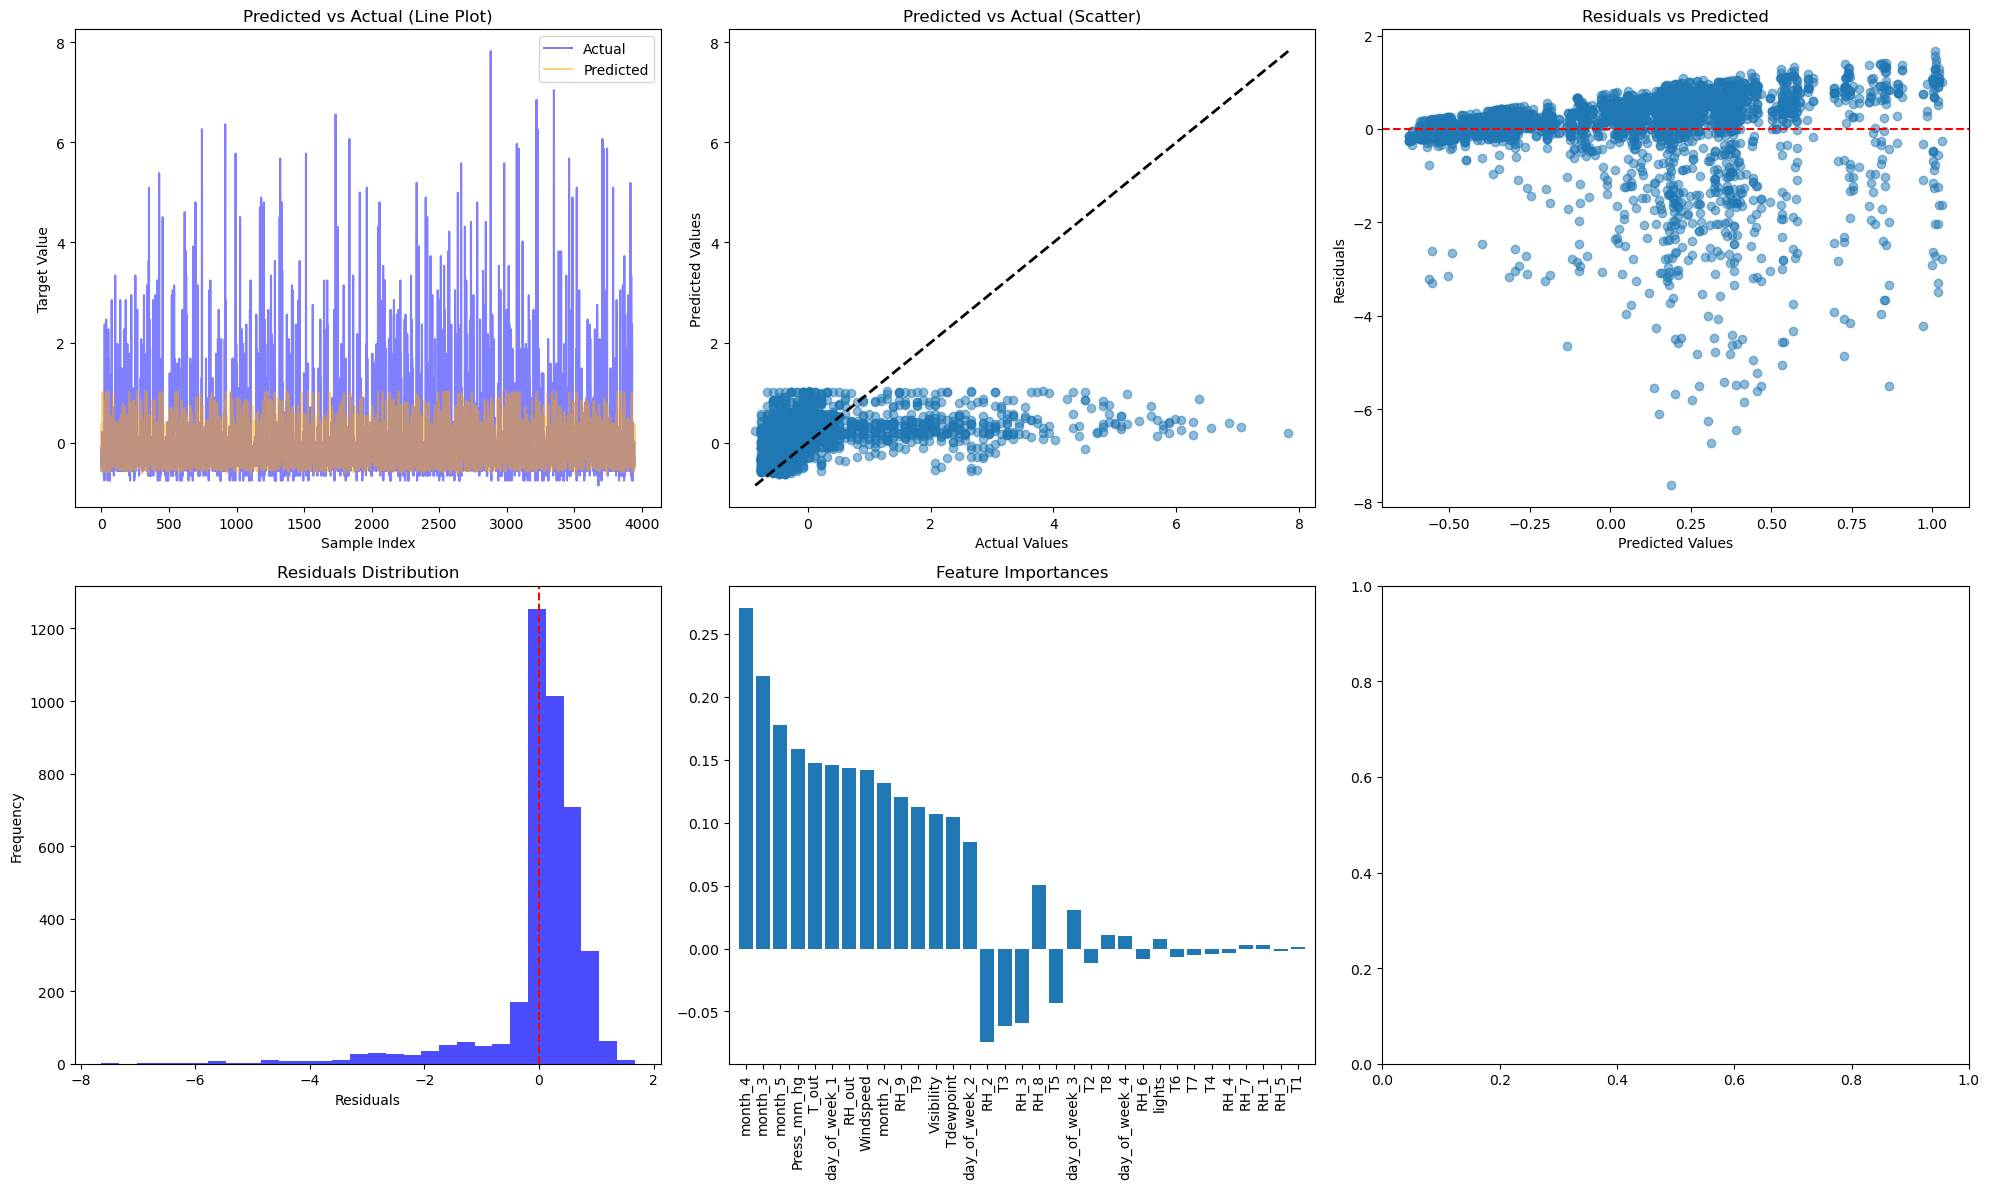

In [92]:
# Let's fit the model with the categorical features
X_train_cat = X_train[:, len(numeric_cols):]
X_test_cat = X_test[:, len(numeric_cols):]
# Fit the model
lin_model.fit(X_train_cat, y_train)
# Evaluate the model
evaluate_linear_model(lin_model, X_test_cat, y_test, feature_names=X.columns)
# The results are surprisingly similar to the previous model
# It tells us that hours, days and months are as important as the numeric features

MAE: 0.50
MSE: 0.73
RMSE: 0.86
R^2: 0.23


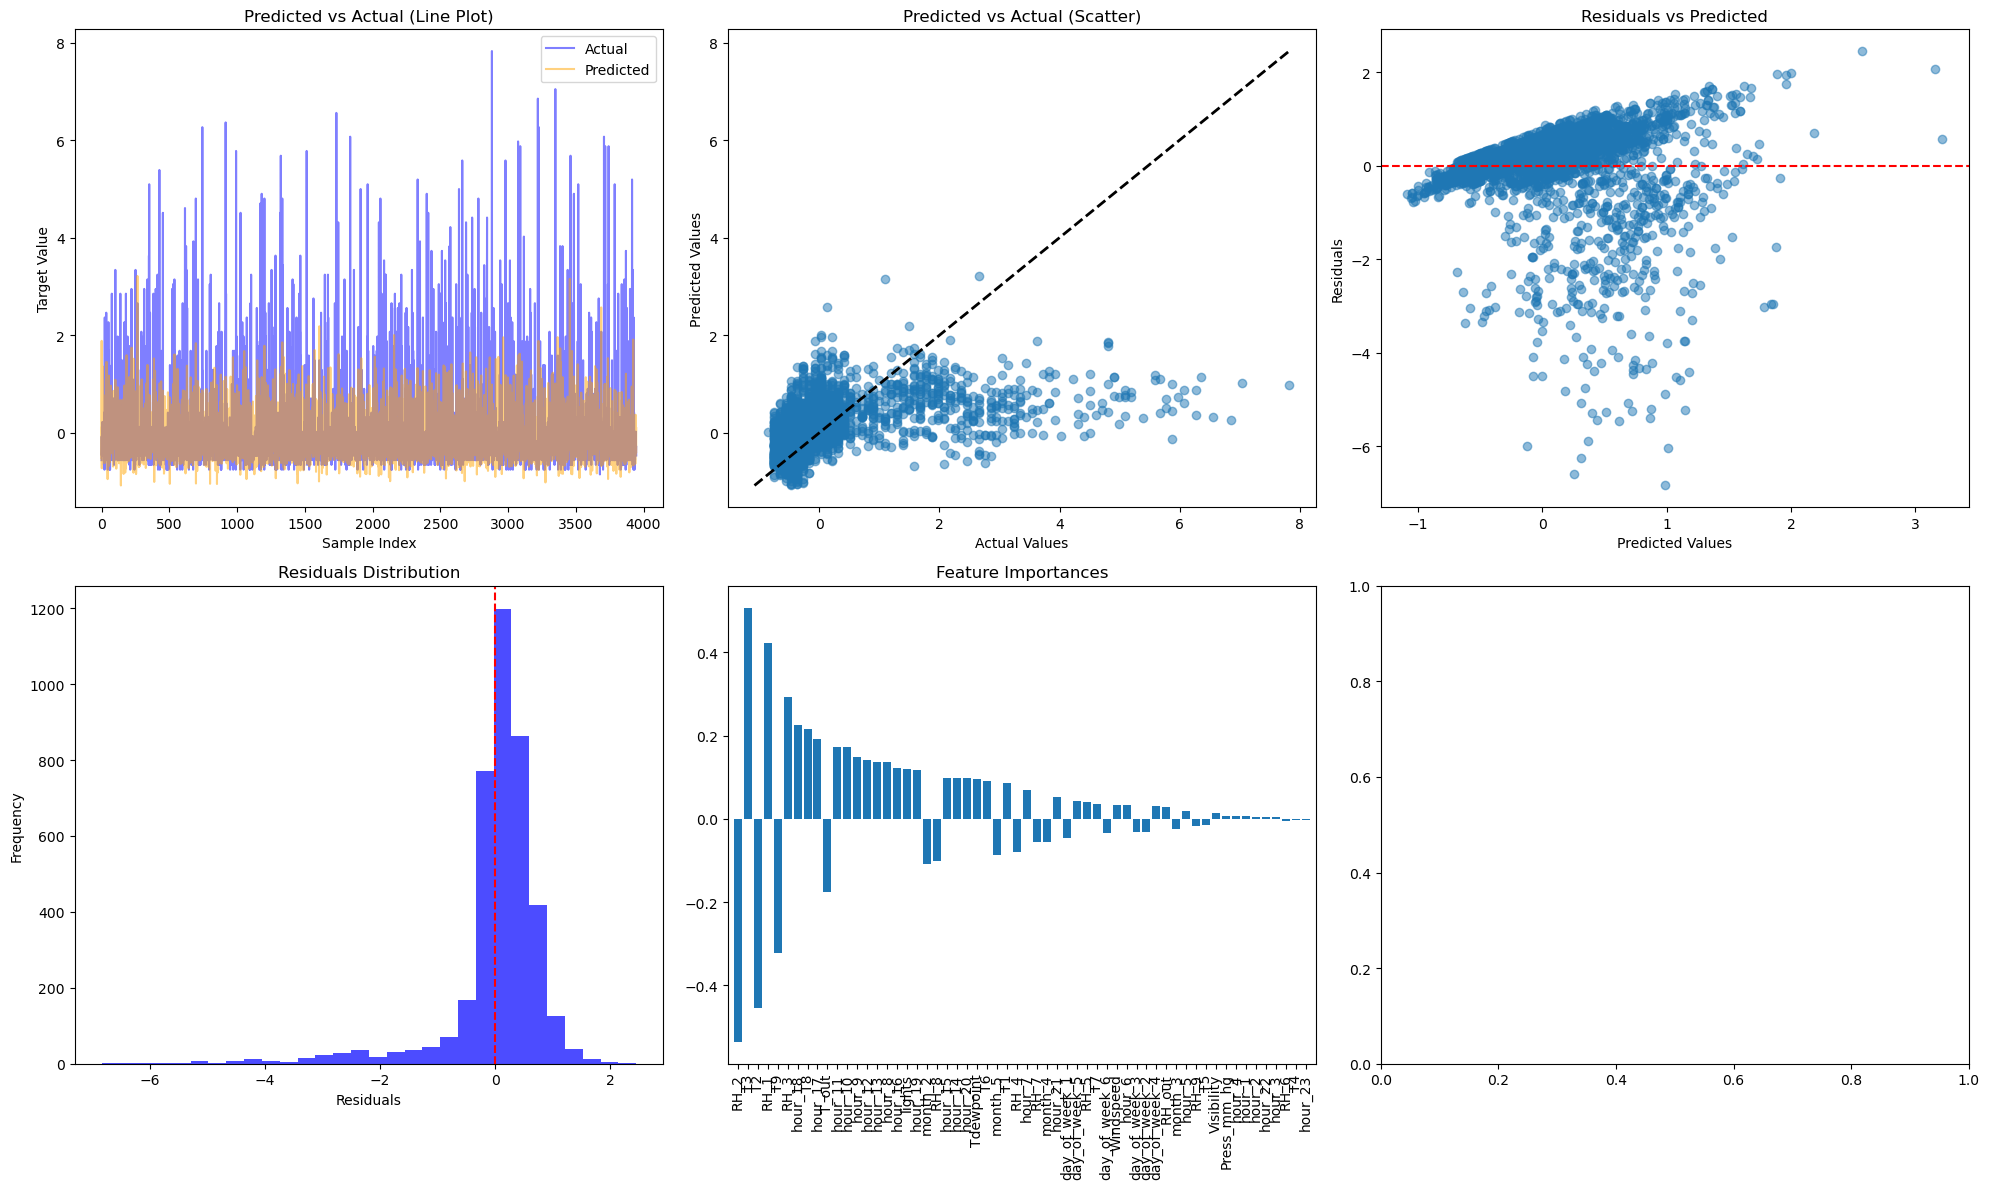

In [93]:
# Let's test with all the features together
lin_model.fit(X_train, y_train)
# Evaluate the model
evaluate_linear_model(lin_model, X_test, y_test, feature_names=X.columns)
# The results are slightly better than the two previous models
# Still, it performs poorly :
# MAE: 0.50
# MSE: 0.73
# RMSE: 0.86
# R^2: 0.23

MAE: 0.50
MSE: 0.77
RMSE: 0.88
R^2: 0.24


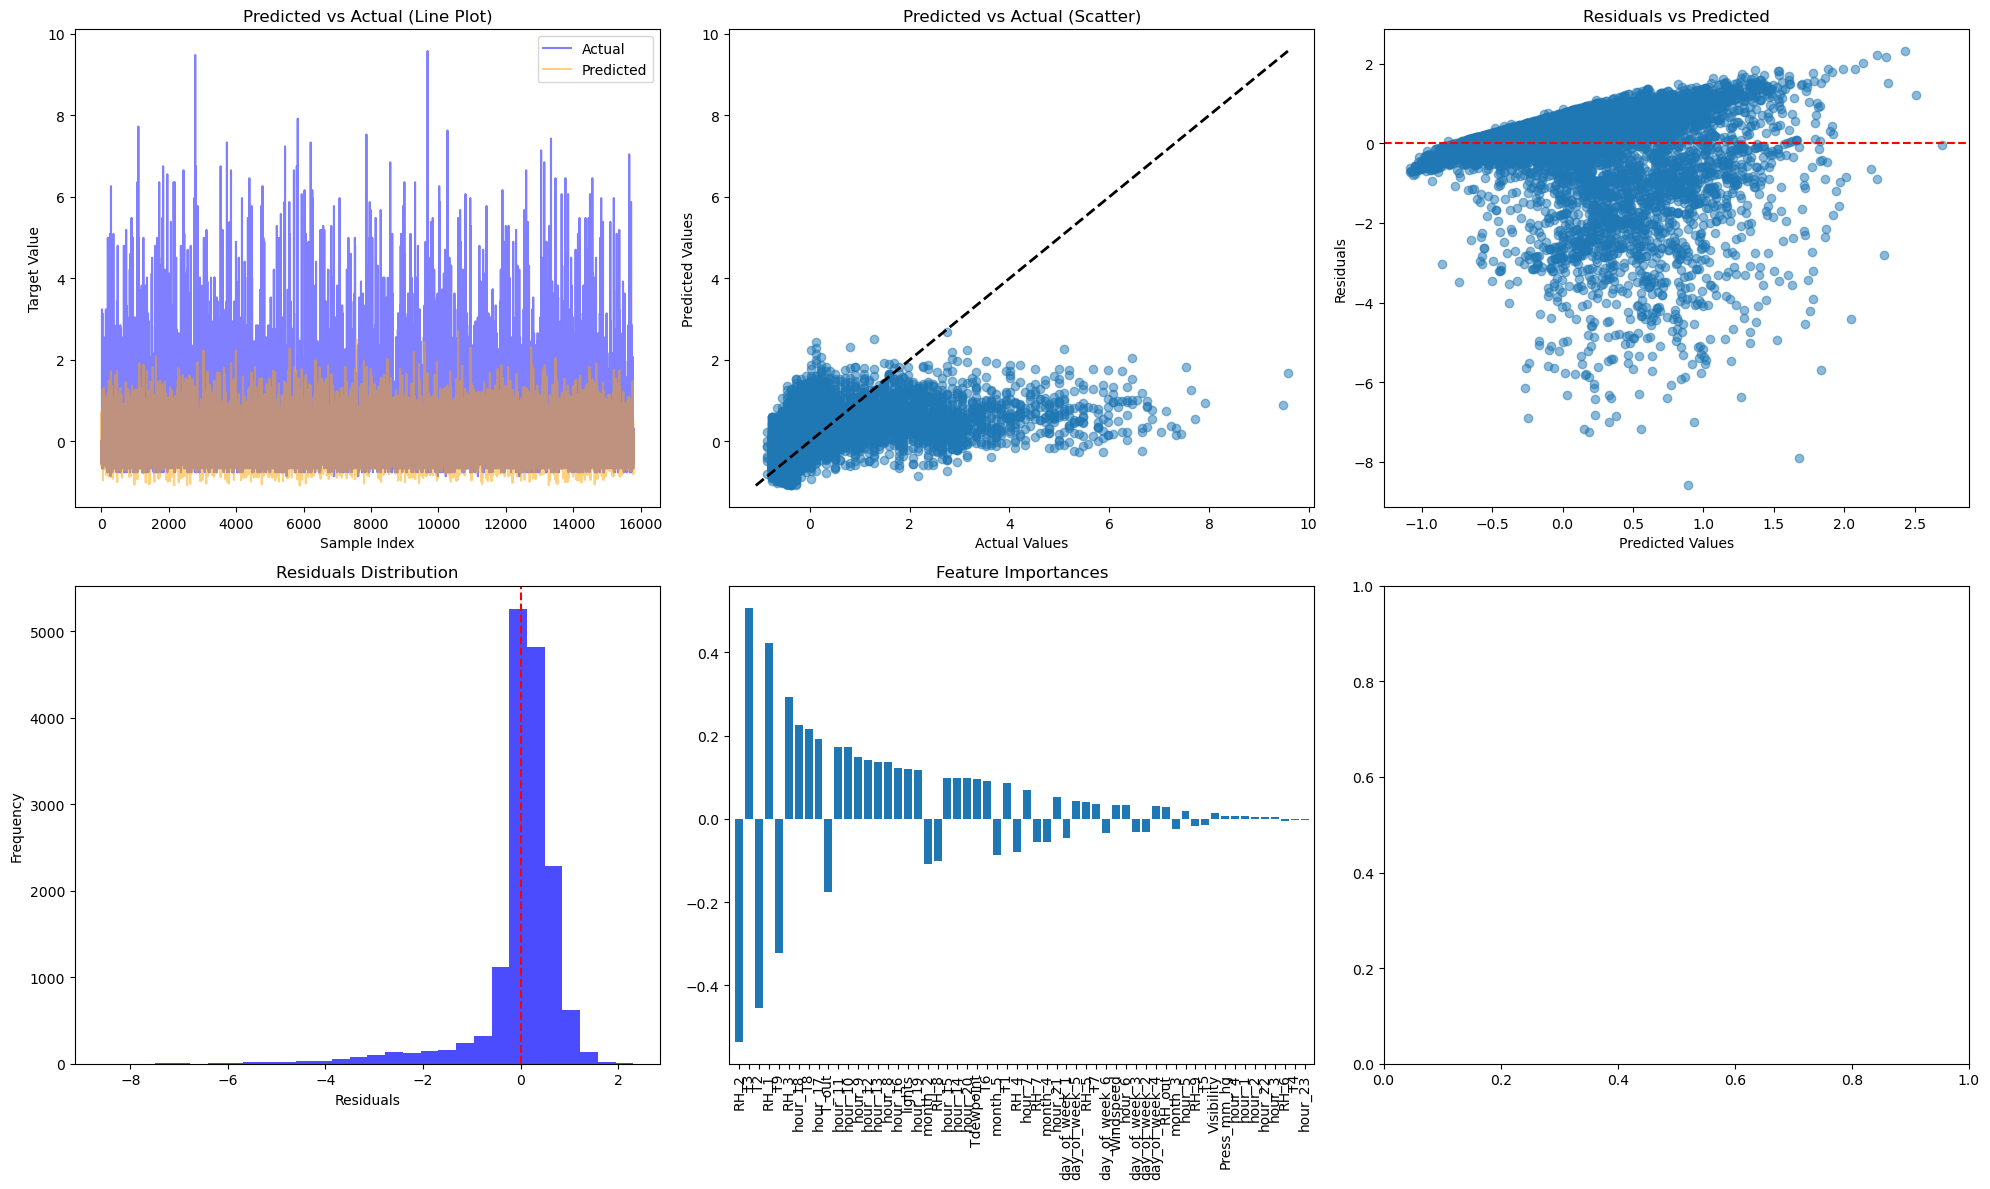

In [ ]:
# Let's check how it performs on the training set
evaluate_linear_model(lin_model, X_train, y_train, feature_names=X.columns)
# It's as bad as on the test set
# This indicates that the model is not learning anything useful from the data.

# Ridge and Lasso Regression

the basic linear regression model is not very good at predicting the target variable.

We can see that a lot of variables are contributing to the prediction of the target variable. So...
### To Continue...